# Estimating defense contract spending across US counties using Ordinary Kriging

This notebook contains the workflow I used to calculate US military spending at the county level between 1999-2022.

The military spending data originated from USAspending.gov, which provides historical records of unclassified prime contracts.  There were 48,730,539 records for the specified time period.  Each contract is associated with a recipient's zip code, and I have already pre-processed the raw data by (1) summing the contract values by zip code by year (see X), and (2) adjusting these aggregated values for inflation (2022 dollars)  This is the state of the data I import below.

Due to the size of the data involved and the compute time required, I ran the models below separately for each year.  This example just uses the data from 1999.


In [1]:
%%capture
!pip install geopandas

In [2]:
%%capture
!pip install rasterio

In [3]:
%%capture
!pip install scikit-gstat

In [4]:
%%capture
!pip install pykrige

In [5]:
%%capture
!pip install rasterstats

In [6]:
%%capture
!pip install shapely

In [17]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import shapes
from rasterio.mask import mask
from shapely.geometry import shape
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from scipy.stats import zscore
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

from rasterstats import zonal_stats

from shapely.geometry import Polygon, Point, box
from shapely.affinity import rotate
import math
import os

In [8]:
# example 1999
gdf = gpd.read_file('/content/drive/MyDrive/Defense/Dissertation/Data/Contracts_year_shapefiles_adj_totals_no_naics/contracts_99.shp')

## I.  Smoothing spatial data to control for spillovers

In the first part of this workflow, I use Ordinary Kriging to interpolate contract values for zip codes that did not themselves receive contracts but were adjacent to those that did.  This was done to control for spatial spillover effects, since the local benefits (or costs) of spending are unlikely to solely accrue to the zips receiving the money.

This exercise yields pseudo-continuous raster value maps of military spending that can be aggregated to other spatial units for further analysis.  


In [9]:
# Calculate the centroid for each polygon, since kriging works best with point data
gdf['geometry'] = gdf.geometry.centroid

gdf.head() # 'gdf' now has point geometries (centroids of the original zip code polygons)

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Unnamed_ 0,Ttl_pop,ZCTA,zcta_1,action_dat,federal_ac,dollars_pe,adjusted_v,geometry
0,47236,47236,B5,G6350,S,1029067.0,0.0,+39.1517426,-085.7252769,NaN,NaN,None,None,1999,0,0.0,0.0,POINT (-4676032.836 4518262.695)
1,47870,47870,B5,G6350,S,8830.0,0.0,+39.3701518,-087.4735141,NaN,NaN,None,None,1999,0,0.0,0.0,POINT (-4730643.89 4661160.522)
2,47851,47851,B5,G6350,S,53547.0,0.0,+39.5735818,-087.2459626,NaN,NaN,None,None,1999,0,0.0,0.0,POINT (-4701315.17 4655253.514)
3,47337,47337,B5,G6350,S,303089.0,0.0,+39.8027537,-085.4372850,25836.0,203.0,47337,47337,1999,0,0.0,0.0,POINT (-4601175.114 4533904.817)
4,47435,47435,B5,G6350,S,13302.0,0.0,+39.2657557,-086.2951577,NaN,NaN,None,None,1999,0,0.0,0.0,POINT (-4690071.355 4567165.244)


In [10]:
gdf.shape # there are about 34k zip codes in the US

(34155, 18)

Because Alaska, Hawaii, and other US territories like Guam and Puerto Rico could introduce distortions into the interpolation analysis, I decided to only include the zip codes from the lower 48 states.

This function clips the spatial extent of the data to a bounding box the user defines.  The one I used describes the continental US's outlying latitudes and longitudes:

- top = 49.3457868 # north lat
- left = -124.7844079 # west long
- right = -66.9513812 # east long
- bottom =  24.7433195 # south lat

In [11]:
def clip_rotate(geodf, bbox, rotation_angle):
    # Ensure the geodataframe is in the correct coordinate system (EPSG:4326)
    if geodf.crs != 'EPSG:4326':
        geodf = geodf.to_crs('EPSG:4326')

    # Create a bounding box
    bbox_polygon = box(*bbox)

    # Clip to bounding box
    geodf_clipped = gpd.clip(geodf, bbox_polygon)

    # Check if there is data after clipping
    if geodf_clipped.empty:
        print("No data within the specified bounding box.")
        return

    # Rotate the geometries
    geodf_clipped['geometry'] = geodf_clipped['geometry'].apply(lambda x: rotate(x, rotation_angle, origin='center'))

    return geodf_clipped

# Define the bounding box (minx, miny, maxx, maxy)
bbox = (-125.0, 24.6, -67.0, 50.0)

In [12]:
gdf = clip_rotate(gdf, bbox, rotation_angle=295)
gdf.shape

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(33299, 18)

I also wanted to standardize the contract values so in the end I could report the relationships between contracts and the dependent variables (i.e., patent counts, number and size of businesses, and related variety) in terms of a standard deviation of spending.

In [13]:
# drop the zero values
gdf_sans_zeros = gdf[gdf['adjusted_v'] != 0]

gdf_sans_zeros['adjusted_v'].mean() # baseline mean

7470494.573261032

In [14]:
def add_zscore_column(df, column_name):
    # Check if the column exists in the DataFrame
    if column_name in df.columns:
        # Calculate z-score
        df[column_name + '_zscore'] = zscore(df[column_name])
    else:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    return df

gdf_sans_zeros = add_zscore_column(gdf_sans_zeros, 'adjusted_v')

gdf_sans_zeros = gpd.GeoDataFrame(gdf_sans_zeros)


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
%%capture
gdf_sans_zeros['adjusted_v_zscore'].describe() # new mean should be about 0 and std deviation should be about 1

Quick plot to check progress:

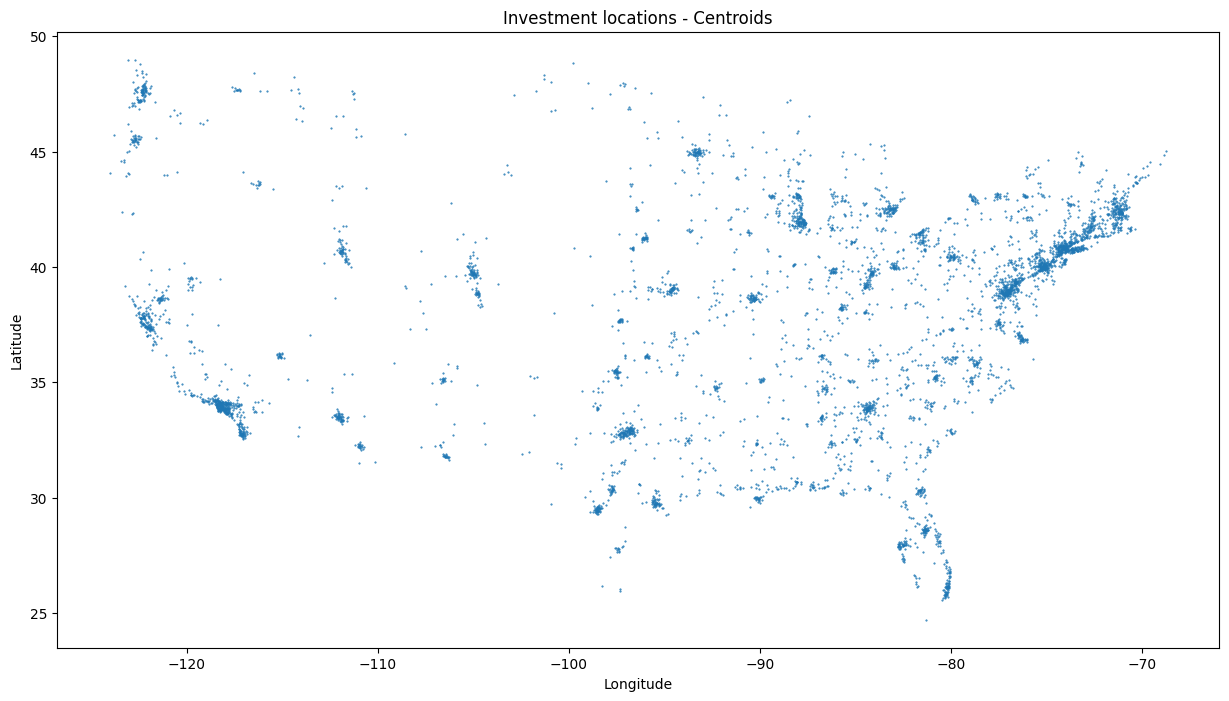

In [16]:
# Extract x and y coordinates from the geometry
gdf_sans_zeros['x'] = gdf_sans_zeros.geometry.x
gdf_sans_zeros['y'] = gdf_sans_zeros.geometry.y

# marker size
sizes = .25

# Create the scatter plot
plt.figure(figsize=(15, 8))
scatter = plt.scatter(gdf_sans_zeros['x'], gdf_sans_zeros['y'], s = sizes)

# Adding titles and labels (optional)
plt.title('Investment locations - Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


Here's where I used the pykrige library's "OrdinaryKriging" function to run the interpolation.  Refer to the [docs](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/generated/pykrige.ok.OrdinaryKriging.html) for more info.

In [18]:
x = gdf_sans_zeros['x']
y = gdf_sans_zeros['y']
z = gdf_sans_zeros['adjusted_v_zscore']

OK = OrdinaryKriging(x,
                     y,
                     z = gdf_sans_zeros['adjusted_v_zscore'],
                     variogram_model = 'exponential')

In [19]:
OK.variogram_model_parameters # automatically calculated using L1 norm minimization scheme

array([ 0.2453873, 10.9541291,  0.757659 ])

In [20]:
min_x, min_y, max_x, max_y = (-125.0, 24.6, -67.0, 50.0) # define spatial extent of the bbox; same as above

gridx = np.arange(min_x, max_x, 0.25, dtype='float64') # longitude
gridy = np.arange(min_y, max_y, 0.25, dtype='float64') # latitude
zstar, ss = OK.execute('grid', gridx, gridy) # zstar is interpolated values, ss is uncertainty

In [21]:
print(zstar.shape)
print(ss.shape)

(102, 232)
(102, 232)


Plot to check work:

Text(0.5, 1.0, 'Defense spending 1999')

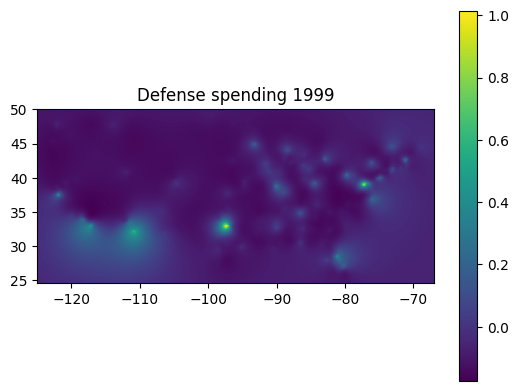

In [22]:
# plt.figure(figsize=(15, 8))
cax = plt.imshow(zstar, extent = (min_x, max_x, min_y, max_y), origin = 'lower')
# plt.scatter(x, y, c= 'k', marker = '.')
cbar = plt.colorbar(cax)
plt.title('Defense spending 1999')

Write the output to a raster file:

In [23]:
# Get the number of rows and columns for the raster
num_rows, num_cols = zstar.shape

# Bounding box coordinates
min_x, min_y, max_x, max_y = (-125.0, 24.6, -67.0, 50.0)

# Create the transform
transform = from_bounds(min_x, min_y, max_x, max_y, num_cols, num_rows)

# Define raster metadata
metadata = {
    'driver': 'GTiff',
    'height': num_rows,
    'width': num_cols,
    'count': 1,  # number of raster bands
    'dtype': zstar.dtype,
    'crs': 'EPSG:4326',  # WGS 84
    'transform': transform
}

# Create the raster file and write zstar to it
with rasterio.open('kriging_output1.tif', 'w', **metadata) as dst:
    dst.write(zstar, 1)  # Write zstar to the first band


Notice the OK model interpolated the entire area of the bbox, not just within the US boundaries.  So now I'll need to clean this up.  To do this, I need a precise outline of the lower 48 states.  You used to be able to call country border data right from geopandas (via the lowres Earth dataset), but unfortunately this function is now deprecated. Incorporating this data now requires downloading the shapefile and importing it separately.

In [24]:
# Load the boundaries of the United States
world = gpd.read_file('/content/drive/MyDrive/Defense/Dissertation/Data/Organizing_data/ne_110m_admin_0_countries.shp')
us = world[world['ADMIN'] == 'United States of America']
us = us.to_crs(crs='EPSG:4326')

# Extract the geometry for masking
geometries = us.geometry.values

# Open the raster file and apply the mask
with rasterio.open('kriging_output1.tif') as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

# Update the metadata to reflect the new dimensions and transform
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped raster
clipped_raster_path = '/content/drive/MyDrive/Defense/Dissertation/Final_map_tifs/kriging99.tif'  # Update path for other years
with rasterio.open(clipped_raster_path, 'w', **out_meta) as dest:
    dest.write(out_image)

In [25]:
# Path to input raster file
tif_path = '/content/drive/MyDrive/Defense/Dissertation/Final_map_tifs/kriging99.tif'  # Update this path for other years

# Read the raster data
with rasterio.open(tif_path) as src:
    # Read the first band
    band1 = src.read(1)
    # Get the affine transformation for the raster
    transform = src.transform
    # Handle nodata value
    nodata = src.nodata

# Convert band1 to an appropriate data type
if band1.dtype == 'float64':  # for handling float64
    band1 = band1.astype('float32')
else:
    band1 = band1.astype('int32')  # Or another type if needed

# mask valid data points (exclude nodata values)
mask = band1 != nodata

# Generate shapes from the raster data
results = shapes(band1, mask=mask, transform=transform)

# Convert shapes to a GeoDataFrame
geoms = []
values = []

for shape_info in results:
    geom, value = shape_info  # shape_info is a tuple (geometry, value)
    geoms.append(shape(geom))  # Convert to Shapely geometry
    values.append(value)

# Create a GeoDataFrame with the geometries and values
gdf = gpd.GeoDataFrame({'geometry': geoms, 'value': values}, crs="EPSG:4326")

# Path to save the GeoJSON file
geojson_path = '/content/drive/MyDrive/Defense/Dissertation/Final_map_geojsons/kriging99.geojson'  # Update this path

# Save the GeoDataFrame to GeoJSON
gdf.to_file(geojson_path, driver='GeoJSON')


In [27]:
gdf_check = gpd.read_file('/content/drive/MyDrive/Defense/Dissertation/Final_map_geojsons/kriging99.geojson')
gdf.shape

(13497, 2)

In [29]:
gdf_check = gdf_check[gdf_check['value'] != 0]
gdf_check.shape

gdf_check.to_file('/content/drive/MyDrive/Defense/Dissertation/Final_map_geojsons/kriging99_no_zeros.geojson')

## II.  Calculate Zonal Statistics: Counties

In this form, smoothed contract data was easily aggregated to counties using zonal statistics functions from the rasterstats library.

In [ ]:
# use county
counties = gpd.read_file('/content/drive/MyDrive/Defense/Dissertation/Data/Income_inequality_county20/cb_2018_us_county_20m.shp')

counties.to_crs(crs = 'EPSG:4326')

In [ ]:
# Load your shapefile into a GeoDataFrame
shapefile_path = ('/content/drive/MyDrive/Defense/Dissertation/Data/Income_inequality_county20/cb_2018_us_county_20m.shp')
gdf = gpd.read_file(shapefile_path)
gdf.to_crs(crs = 'EPSG:4326')

# Path to your raster file
raster_path = '/content/drive/MyDrive/Defense/Dissertation/Final_map_tifs/kriging99.tif'

# Calculate zonal statistics
stats = zonal_stats(shapefile_path, raster_path, stats="count min mean max median")

# Add the statistics to the GeoDataFrame
# Assuming the order of features in GeoDataFrame is the same as in the shapefile
gdf['min'] = [stat['min'] for stat in stats]
gdf['mean'] = [stat['mean'] for stat in stats]
gdf['max'] = [stat['max'] for stat in stats]
gdf['median'] = [stat['median'] for stat in stats]

# Now 'gdf' contains the original data plus the new columns with zonal statistics

gdf.to_file('/content/drive/MyDrive/Defense/Dissertation/Data/Zonal_statistics_counties/exponential99.shp')

/usr/local/lib/python3.10/dist-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
